In [16]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns

from scipy.sparse import csr_matrix, coo_matrix

import torch
import implicit
from implicit.evaluation import mean_average_precision_at_k

from tqdm.notebook import tqdm
from collections import defaultdict

import logging
logging.basicConfig(level=logging.INFO)
logging.info("test")

import sys
sys.path.append("..")
from src.utils import *

SEED = 1

INFO:root:test


In [2]:
articles = pd.read_csv("../input/articles_proc.csv", dtype={"article_id": str})
customers = pd.read_csv("../input/customers_proc.csv")
transactions_full = pd.read_csv("../input/transactions_full.csv", 
                                dtype={"article_id": str}, parse_dates=["t_dat"])
subm = pd.read_csv("../input/sample_submission.csv")

In [3]:
class DatasetMaker:
    def __init__(self, 
                 articles, 
                 customers):        
        self.articles_num2id = dict(enumerate(articles["article_id"].unique()))
        self.articles_id2num = {id_: num for num, id_  in self.articles_num2id.items()}

        self.customers_num2id = dict(enumerate(customers["customer_id"].unique()))
        self.customers_id2num = {id_: num for num, id_ in self.customers_num2id.items()}
        
        self.data_shape = (customers.shape[0], articles.shape[0])
    
    def get_coo_matrix(self, data):
        data_csr = coo_matrix(
            (
                np.ones(data.shape[0]), 
                (
                    data["customer_id"].map(self.customers_id2num), 
                    data["article_id"].map(self.articles_id2num)
                )
            ),
            shape=self.data_shape,
            dtype=np.uint8
        )
        return data_csr
        
    def split_data(self, data, val_days: int = 7):
        val_split_date = data['t_dat'].max() - pd.Timedelta(val_days)
        
        data_train = data[data['t_dat'] < val_split_date]
        data_val = data[data['t_dat'] >= val_split_date]
        return data_train, data_val
    
    def limit_data(self, data, min_days_ago: int = 30, max_days_ago: int = 0):
        min_split_date = data['t_dat'].max() - pd.Timedelta(days=min_days_ago)
        max_split_date = data['t_dat'].max() - pd.Timedelta(days=max_days_ago)
        
        return data[data['t_dat'].between(min_split_date, max_split_date)]

In [4]:
train_weeks = 9999
factors = 200
iterations = 5
regularization = 0.01
random_state = 1

dm = DatasetMaker(articles, customers)
data = dm.limit_data(transactions_full, 
                     min_days_ago=7 * (train_weeks), 
                     max_days_ago=0)
train = dm.get_coo_matrix(data).tocsr()

als = implicit.als.AlternatingLeastSquares(
    factors=factors, 
    iterations=iterations, 
    regularization=regularization,
    use_gpu=True,
    num_threads=16,
    random_state=1
)

als.fit(train, show_progress=True)

  0%|          | 0/5 [00:00<?, ?it/s]

## Покупки  пользователей за всё время 

In [5]:
def get_item_dict(transactions):
    purchase_dict = {}

    for i, x in enumerate(zip(transactions['customer_id'], transactions['article_id'])):
        cust_id, art_id = x
        if cust_id not in purchase_dict:
            purchase_dict[cust_id] = {}

        if art_id not in purchase_dict[cust_id]:
            purchase_dict[cust_id][art_id] = 0

        purchase_dict[cust_id][art_id] += 1

    return purchase_dict

purchase = get_item_dict(transactions_full)

## Покупки за последнюю неделю 

In [6]:
last_date = transactions_full["t_dat"].max()
article_counter_w1 = (
    transactions_full[transactions_full["t_dat"] >= last_date - pd.Timedelta(days=7)]
        .groupby("article_id").size()
).to_dict()

In [8]:
len(article_counter_w1)

18684

In [14]:
article_counter_w1 = dict(filter(lambda x: x[1] > 10, article_counter_w1.items()))

## Отображение товаров в релевантные, продающиеся сейчас

In [69]:
actual_article_list = list(
    map(lambda x: dm.articles_id2num[x],
        list(article_counter_w1.keys())
       )
)

similar_article_dict = defaultdict(list)
for article_id, article_num in tqdm(dm.articles_id2num.items()):
    items, scores = als.similar_items(
        itemid=article_num, 
        N=3, 
        items=actual_article_list
    )
    for i in range(len(items)):
        item, score = items[i], scores[i]
        article_id_simular = dm.articles_num2id[item]
        similar_article_dict[article_id].append((article_id_simular, score))

  0%|          | 0/105542 [00:00<?, ?it/s]

## Отображение покупок в релевантные 

In [70]:
(sum(list(article_counter_w1.values())) / len(article_counter_w1.values())) ** 0.3

3.1944895134444495

In [71]:
actual_purchase = defaultdict(dict)
for customer_id, purcase_dict in tqdm(purchase.items()):
    for article_id, cnt in purcase_dict.items():
        for similar, score in similar_article_dict[article_id]:
            similar_counter_w1 = article_counter_w1[similar]
            if similar not in actual_purchase[customer_id]:
                actual_purchase[customer_id][similar] = [0, 0, 0]
            actual_purchase[customer_id][similar][0] += cnt * score * (similar_counter_w1)**2
            actual_purchase[customer_id][similar][1] += cnt
            actual_purchase[customer_id][similar][2] = similar_counter_w1

  0%|          | 0/1362281 [00:00<?, ?it/s]

In [72]:
customer_id = "000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318"
actual_purchase[customer_id]

{'0914404002': [510.5710506439209, 2, 20],
 '0837014001': [1128.3324790000916, 2, 31],
 '0589440002': [611.7770762443542, 2, 23],
 '0855706002': [92.68264675140381, 1, 12],
 '0821398001': [589.5621003508568, 1, 31],
 '0855706001': [103.56133681535721, 1, 13],
 '0877137002': [222.45421409606934, 1, 20],
 '0825782001': [82.80710557103157, 1, 13],
 '0727414001': [95.35414505004883, 1, 14],
 '0351484002': [577.3282036185265, 3, 15],
 '0924642001': [283.2767639160156, 1, 32],
 '0754362022': [109.20735597610474, 1, 20],
 '0891763004': [2305.5630865693092, 2, 61],
 '0873045002': [1080.321840941906, 2, 45],
 '0564358012': [304.69861030578613, 1, 20],
 '0766402005': [290.4226303100586, 1, 20],
 '0564358033': [966.1469721794128, 2, 26],
 '0795836001': [283.62674564123154, 1, 21],
 '0702932002': [255.7565450668335, 1, 20],
 '0794468001': [105.51517581939697, 1, 12],
 '0861558002': [769.8151391744614, 1, 33],
 '0766495013': [370.36579859256744, 1, 23],
 '0851400001': [933.7699115276337, 1, 35],
 '

## Предсказания 

In [73]:
popular_w1 = list(
    map(
        lambda x: x[0], 
        list(sorted(article_counter_w1.items(), key=lambda x: -x[1]))
    )
)[:12]

In [74]:
def get_prediction(customer_id):
    actual_sorted = list(
        map(lambda x: x[0],
            sorted(
                list(
                    actual_purchase[customer_id].items()), 
                key=lambda x: -x[1][0]
            )
           )
    )
    
    return " ".join((actual_sorted + popular_w1)[:12])

In [75]:
customers["prediction"] = customers["customer_id"].apply(get_prediction)

In [76]:
customers[["customer_id", "prediction"]]

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006 0929165002 0568601044 0884319001 09...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0865799006 0673677002 0809238001 0805947001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0904584009 0805000007 0794321007 0685813018 06...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0740922001 0806783002 0801512004 0912204008 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152002 0898573003 0730683050 0791587015 08...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0906352001 0456163085 0822344001 0719655001 08...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846027 0762846031 0762846026 0856440002 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846027 0781613006 0762846026 0706016002 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0714790020 0714790028 0831302001 0874113005 08...


In [77]:
(
    customers[["customer_id", "prediction"]]
        .to_csv("../output/36.als_similarity3_cnt_mul_score_mul_generalcnt2_popular_w1.csv", index=False, header=True)
)

## Analytics 

In [33]:
customer_id = [
    "000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318",
    "00039306476aaf41a07fed942884f16b30abfa83a2a8bea972019098d6406793",
    "0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf4672f30b3e622fec55"
][2]

In [34]:
transactions_full[transactions_full["customer_id"] == customer_id]

,t_dat,customer_id,article_id,price,sales_channel_1_flg,sales_channel_2_flg
23548795,2020-03-20,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0823025001,0.031763,0,1
23548796,2020-03-20,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0377277001,0.008458,0,1
23548797,2020-03-20,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0870962001,0.033881,0,1
28287018,2020-06-29,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0733749001,0.005068,0,1
28287019,2020-06-29,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0875329001,0.013542,0,1
29794827,2020-08-02,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0784053005,0.043203,0,1
29794828,2020-08-02,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0873217004,0.025407,0,1
29794829,2020-08-02,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0873217004,0.025407,0,1
30180374,2020-08-11,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0927358001,0.022017,0,1
30180375,2020-08-11,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0920012001,0.025407,0,1


In [35]:
def show_purchase(customer_id, transactions):
    cust_tr = transactions[transactions["customer_id"] == customer_id]
    dates = cust_tr["t_dat"].unique()
    for j, t_dat in enumerate(sorted(dates)):
        cust_tr_dat = cust_tr[cust_tr["t_dat"] == t_dat]
        print(t_dat)
        for i in range(cust_tr_dat.shape[0]):
            article_id = cust_tr_dat.iloc[i]["article_id"]
            t_dat = cust_tr_dat.iloc[i]["t_dat"]
            try:
                plt.imshow(plt.imread(f"../input/images/{article_id[:3]}/{article_id}.jpg"))
                plt.show()
            except:
                print("Error")

2020-03-20T00:00:00.000000000


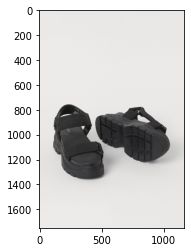

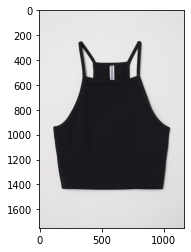

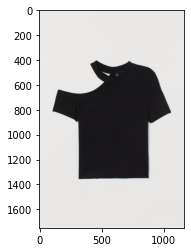

2020-06-29T00:00:00.000000000


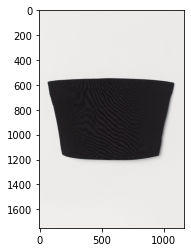

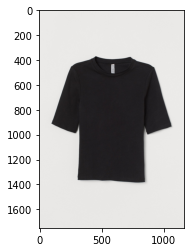

2020-08-02T00:00:00.000000000


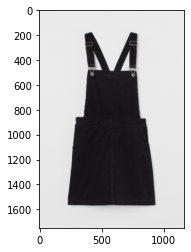

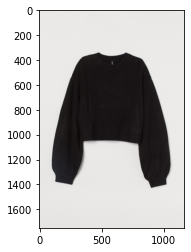

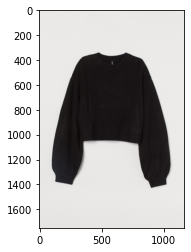

2020-08-11T00:00:00.000000000


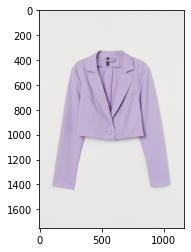

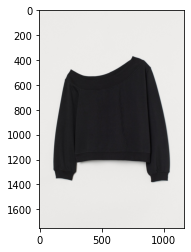

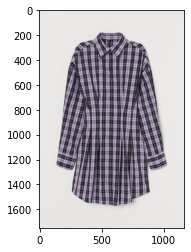

2020-09-05T00:00:00.000000000


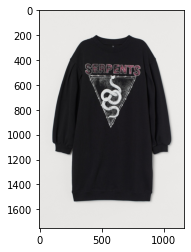

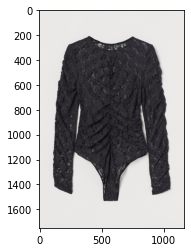

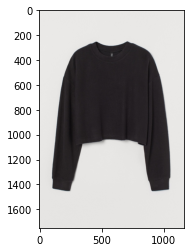

2020-09-12T00:00:00.000000000


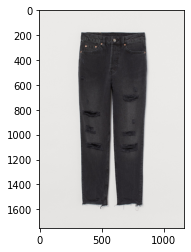

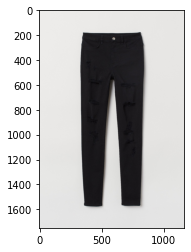

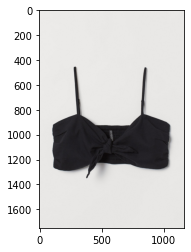

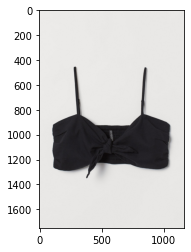

2020-09-14T00:00:00.000000000


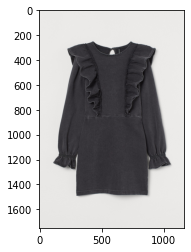

2020-09-22T00:00:00.000000000


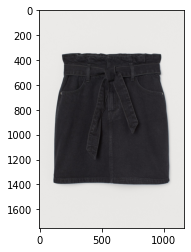

In [36]:
show_purchase(customer_id, transactions_full)

In [152]:
customers[customers.customer_id == customer_id]["prediction"].iloc[0]

'0873217004 0907702002 0916256001 0842062003 0880238006 0819423001 0859205001 0850587001 0880312003 0880017001 0888294001 0920012001'

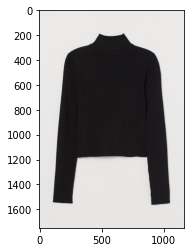

In [158]:
show_article("0819423001")